# Face to Emoji (CS445 Course Project)

In [1]:
import os
from tqdm import tqdm
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms

## Parameters

In [2]:
# training parameters
BATCH_SIZE = 32
NUM_EPOCHS = 200
LEARNING_RATE = 1e-3
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# path parameters
DATA_PATH = './data'
WEIGHTS_PATH = "./weights/resnet18_affectnet.pth"
EMOJI_PATH = "./emoji"

# EMOJI parameters
NUM_EMOJI = 8
EMOJI_TYPES = ["anger", "contempt", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

## Data

In [3]:
# Load ImageNette dataset
img_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((224, 224))]
)
data_set = datasets.ImageFolder(root="./data/AffectNet", transform=img_transform)
train_set, test_set = torch.utils.data.random_split(data_set, [int(0.8*len(data_set)), len(data_set)-int(0.8*len(data_set))])

train_loader = torch.utils.data.DataLoader(train_set,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(train_set,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

## Motify model

In [4]:
pipeline = models.resnet18(pretrained=True)
num_ftrs = pipeline.fc.in_features
pipeline.fc = nn.Linear(num_ftrs, NUM_EMOJI)
pipeline = pipeline.to(device)

## Training

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pipeline.parameters(), lr=LEARNING_RATE, momentum=0.9)

In [7]:
for epoch in tqdm(range(NUM_EPOCHS)):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader, 0):
        # get the inputs; data is a list of [images, labels]
        images, labels = images.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = pipeline(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')



## Save model

In [ ]:
torch.save(pipeline.state_dict(), WEIGHTS_PATH)

## Load model

In [ ]:
pipeline = models.resnet18(pretrained=True)
num_ftrs = pipeline.fc.in_features
pipeline.fc = nn.Linear(num_ftrs, NUM_EMOJI)
pipeline = pipeline.to(device)

pipeline.load_state_dict(torch.load(WEIGHTS_PATH))
pipeline.eval()

## test

In [ ]:
correct = 0
total = 0
for i, data in enumerate(test_loader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    # predict
    outputs = pipeline(inputs).detach()
    preds = np.argmax(outputs, axis=1)
    for j in range(len(preds)):
        total += 1
        if labels[j] == preds[j]:
            correct += 1
print("accuracy: ", correct / total)

## Face detection in a image

To Sirui: 你跑的时候可以直接从这里开始跑

In [ ]:
import os
from tqdm import tqdm
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms

In [83]:
import random
from PIL import Image, ImageDraw
from facenet_pytorch import MTCNN, InceptionResnetV1

In [ ]:
# training parameters
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# path parameters
WEIGHTS_PATH = "./weights/resnet18_ck.pth"
EMOJI_PATH = "./emoji"

# EMOJI parameters
NUM_EMOJI = 7
# NUM_EMOJI = 8
EMOJI_TYPES = ["anger", "contempt", "disgust", "fear", "happy", "sad", "surprise"]
# EMOJI_TYPES = ["anger", "contempt", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

In [45]:
def prepare_model():
    # Emotion Prediction
    pipeline = models.resnet18(pretrained=True)
    num_ftrs = pipeline.fc.in_features
    pipeline.fc = nn.Linear(num_ftrs, NUM_EMOJI)
    emotion_model = pipeline.to(device)

    emotion_model.load_state_dict(torch.load(WEIGHTS_PATH))
    emotion_model.eval()
    
    # Face Detection
    mtcnn = MTCNN(keep_all=True, device=device)
    
    return emotion_model, mtcnn
    
def prepare_emoji():
    emoji_images = {}
    for emo in EMOJI_TYPES:
        emoji_images[emo] = []
        emoji_images_path = os.path.join(EMOJI_PATH, emo)
        for img in os.listdir(emoji_images_path):
            if ".png" in img:
                emoji_images[emo].append(Image.open(os.path.join(emoji_images_path, img)))
        
    return emoji_images

In [107]:
# We use models and emoji images as global variables
emotion_predictor, face_detector = prepare_model()
emoji_images = prepare_emoji()

class Face2emoji:
    """
        This class contains the pipeline of detecting faces, predicting emotions and pasting emojis onto the image.
        When precess a new image, use reset() or create a new Face2emoji class.
    """
    def __init__(self, image):
        self.image = image
        self.boxes = []
        self.faces = []
        self.emotions = []
        self.centers = []
        self.sizes = []
        self.toTensor = transforms.ToTensor()

    def reset(self, image):
        self.image = image
        self.boxes = []
        self.faces = []
        self.emotions = []
        self.centers = []
        self.sizes = []

    def _detect_faces(self):
        # Detect faces
        self.boxes, _ = face_detector.detect(self.image)
        
    def draw_faces(self):
        # Draw faces
        # For visualization
        img_draw = self.image.copy()
        draw = ImageDraw.Draw(img_draw)
        for box in self.boxes:
            draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
        display(img_draw)
    
    def _get_faces(self):
        # Get images which each of them only contain a single face
        # The output will be used for emotion prediction
        for box in self.boxes:
            face = self.image.crop(box)
            self.faces.append(face)

    def _predict_emotions(self):
        # Use pretrained network to predict emotion
        # Current network pipeline: Pretrained ResNet18
        for face in self.faces:
            emo_prob = emotion_predictor(self.toTensor(face).unsqueeze(0)).detach().numpy()
            emo = np.argmax(emo_prob)
            self.emotions.append(EMOJI_TYPES[emo])
    
    def _get_centers_and_sizes(self):
        # Centers: Let us know where we should paste the emoji image
        # Size: Let use know how big we should resize the emoji image so that it can cover the whole original face
        for box in self.boxes:
            self.centers.append(((box[0]+box[2])/2, (box[1]+box[3])/2))
            self.sizes.append(max(box[2]-box[0], box[3]-box[1]))
            
    def _get_random_emoji_image(self, emo):
        # For diversity, we put multiple emoji images in one emotion folder
        # Randonly pick one when we use it
        return random.choice(emoji_images[emo])

    def paste_emoji(self):
        # Paste the emoji image onto the original image. And display it
        out_image = self.image.copy()
        for i in range(len(self.emotions)):
            emoji_image = self._get_random_emoji_image(self.emotions[i])
            emoji_image = emoji_image.resize((int(self.sizes[i]), int(self.sizes[i])))
            emoji_size = emoji_image.size
            out_image.paste(emoji_image, [int(self.centers[i][0]-emoji_image.size[0]/2), int(self.centers[i][1]-emoji_image.size[1]/2)])
            
        display(out_image)
 
    def run(self):
        # Use to run the whole experiment
        self._detect_faces()
        self._get_faces()
        self._get_centers_and_sizes()
        self._predict_emotions()
        self.paste_emoji()
        


## Run experiment

In [108]:
exp = Face2emoji(Image.open("./img/test.png"))

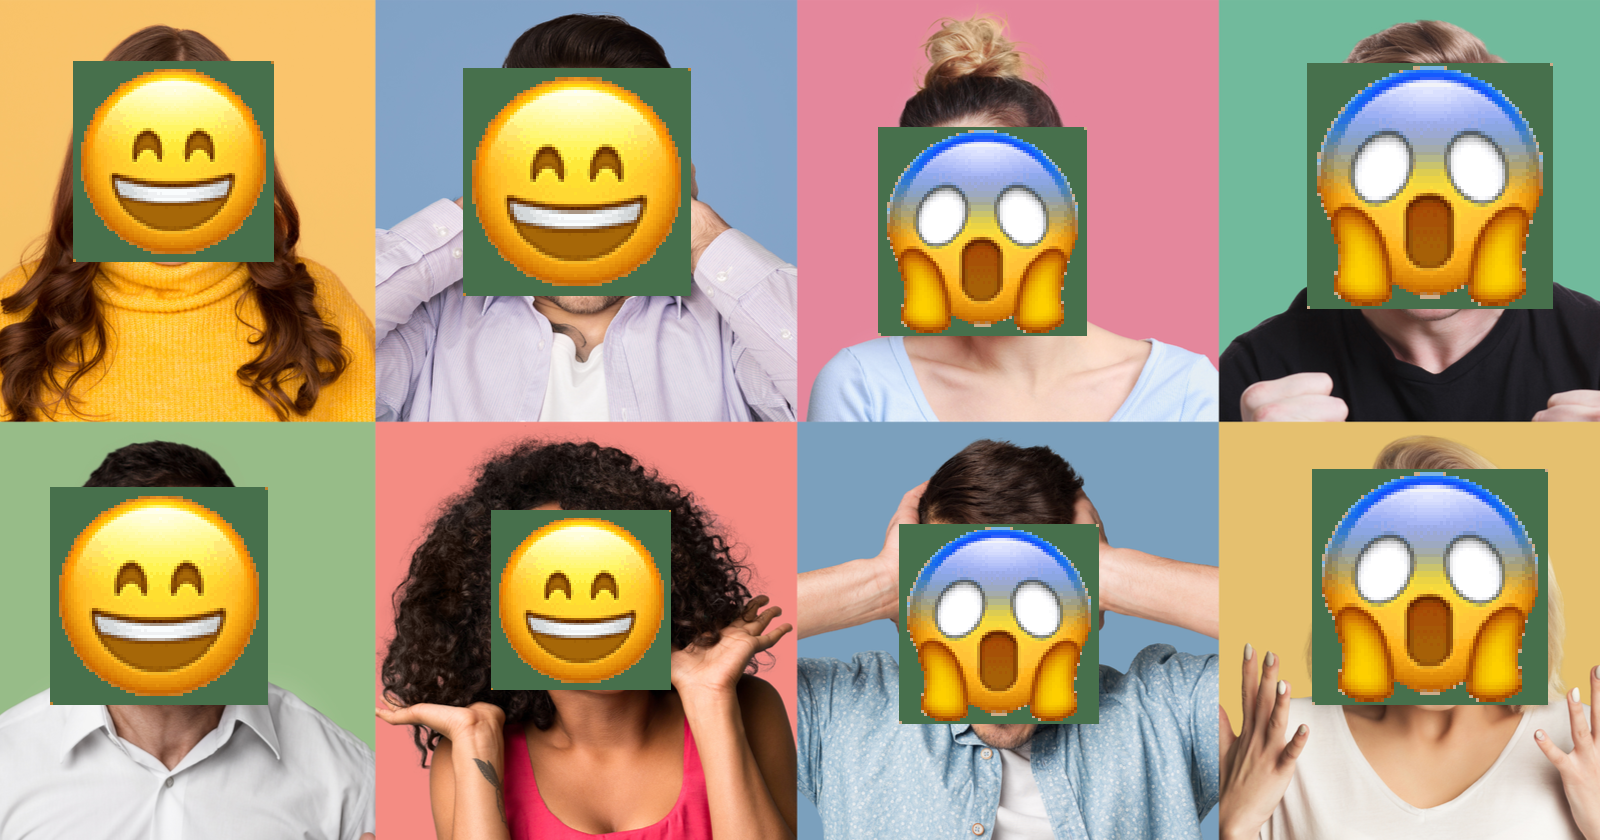

In [109]:
out = exp.run()